In [15]:
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [16]:
# General definitions
rootdir = ".."
data_directory = os.path.join(rootdir, "hpob")
search_space_id = "5527"
part = "test"

In [17]:
# Approach definitions
num_particles = 100
num_random_trajectories = 100
horizon = 3
optimizer="sgd"
lr = 0.001
mpc_seed = 5

In [18]:
# get part files
with open(os.path.join(data_directory, "splits", f"{part}.json"), "r") as f:
    files = json.load(f)[search_space_id]

In [19]:
# initialize search space results
search_space_results = []
search_space_results_rank = []

col_names = None
# get individual task names
for task in files:

    approach_results = dict()
    variant_name = "{pre_trained} {apply_lookahead}"
    for pre_trained in [True, False]:
        for apply_lookahead in [True, False]:
            approach_results_path = os.path.join(rootdir, "results", "pre-trained" if pre_trained else "random-initialization",
                                                 search_space_id, f"horizon-{horizon}",
                                                 f"trajectories-{num_random_trajectories}",
                                                 f"particles-{num_particles}",
                                                 "LookAhead" if apply_lookahead else "MPC",
                                                 optimizer, f"lr-{lr}", f"mpc-{mpc_seed}", task)
            temp_results = (100 * pd.read_csv(os.path.join(approach_results_path, "results.csv"), index_col=0)).round(4)
            approach_results.update({variant_name.format(pre_trained="pre-trained" if pre_trained else "random",
                                                         apply_lookahead="LookAhead" if apply_lookahead else "MPC"):temp_results})

    task_results = []
    task_results_rank = []
    for hpo_seed in range(5):

        legacy_results_path = os.path.join(rootdir, "legacy_results", search_space_id, f"{hpo_seed}", task)
        legacy_results = pd.read_csv(os.path.join(legacy_results_path, "results.csv"), index_col=0)

        seed_results = legacy_results.copy()
        for approach in approach_results:
            seed_results = pd.concat([seed_results, pd.DataFrame(approach_results[approach][f"seed-{hpo_seed}"]).rename(
                columns={f"seed-{hpo_seed}": approach})], axis=1)
        seed_results = seed_results.fillna(0)

        if col_names is None:
            col_names = seed_results.columns
        task_results.append(seed_results.values[:96])
        seed_results_rank = seed_results.rank(axis=1)
        task_results_rank.append(seed_results_rank.values[:96])
    search_space_results.append(np.stack(task_results))
    search_space_results_rank.append(np.stack(task_results_rank))

In [20]:
# average first over tasks then over seeds
search_space_results_mean = pd.DataFrame(np.stack(search_space_results).mean(axis=0).mean(axis=0), columns=col_names)
search_space_results_std = pd.DataFrame(np.stack(search_space_results).mean(axis=0).std(axis=0), columns=col_names)

search_space_results_rank_mean = pd.DataFrame(np.stack(search_space_results_rank).mean(axis=0).mean(axis=0), columns=col_names)
search_space_results_rank_std = pd.DataFrame(np.stack(search_space_results_rank).mean(axis=0).std(axis=0), columns=col_names)


In [21]:
search_space_results_mean

,RGPE,GCP+Prior,DKLM,FSBO,DKLM (RI),ABLR,TST-R,TAF-R,Random,Bohamiann,GP,DNGO,Deep Kernel GP,pre-trained LookAhead,pre-trained MPC,random LookAhead,random MPC
0,12.227405,12.227405,12.227405,12.227405,12.227405,12.227405,12.227405,12.227405,12.227405,12.227405,12.227405,12.227405,12.227405,12.227407,12.227407,12.227407,12.227407
1,10.194597,11.751916,11.951245,11.224503,11.069116,12.153333,10.694897,10.948950,12.227405,11.452897,11.586334,11.958928,11.890680,11.845217,11.859683,11.773017,11.931720
2,9.771891,11.153676,11.490784,10.315725,11.031295,11.797440,10.257736,10.511788,12.117422,11.294195,11.472614,11.615641,11.605623,11.624317,10.711770,11.681693,10.920793
3,9.673315,10.935787,10.813770,10.315725,10.848646,11.767315,9.945312,9.798447,12.096267,10.477989,10.562053,11.485993,10.734349,10.641173,10.444513,9.587213,10.809257
4,9.261869,10.923096,10.631122,10.311498,10.545493,11.240907,9.778200,9.788405,11.937565,10.171119,9.495386,10.415528,9.807384,10.482433,9.891507,8.877173,10.270753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,4.061223,2.974729,0.790083,2.383105,1.593154,4.645643,5.844129,5.175853,4.257784,0.723888,5.099636,4.050023,2.737320,5.525650,4.342683,3.948677,3.554503
92,4.061223,2.974729,0.790083,2.383105,1.593154,4.371671,5.752805,5.084529,4.257784,0.723888,5.099636,4.050023,2.737320,5.523540,4.342683,3.948677,3.554503
93,4.061223,2.974729,0.790083,2.109132,1.593154,4.318757,5.707143,5.084529,4.257784,0.723888,5.099636,4.050023,2.737320,5.523540,4.342683,3.948677,3.554503
94,4.061223,2.972621,0.790083,2.109132,1.593154,4.318757,5.707143,5.084529,4.257784,0.723888,5.099636,4.047915,2.737320,5.523540,4.342683,3.948677,3.550277


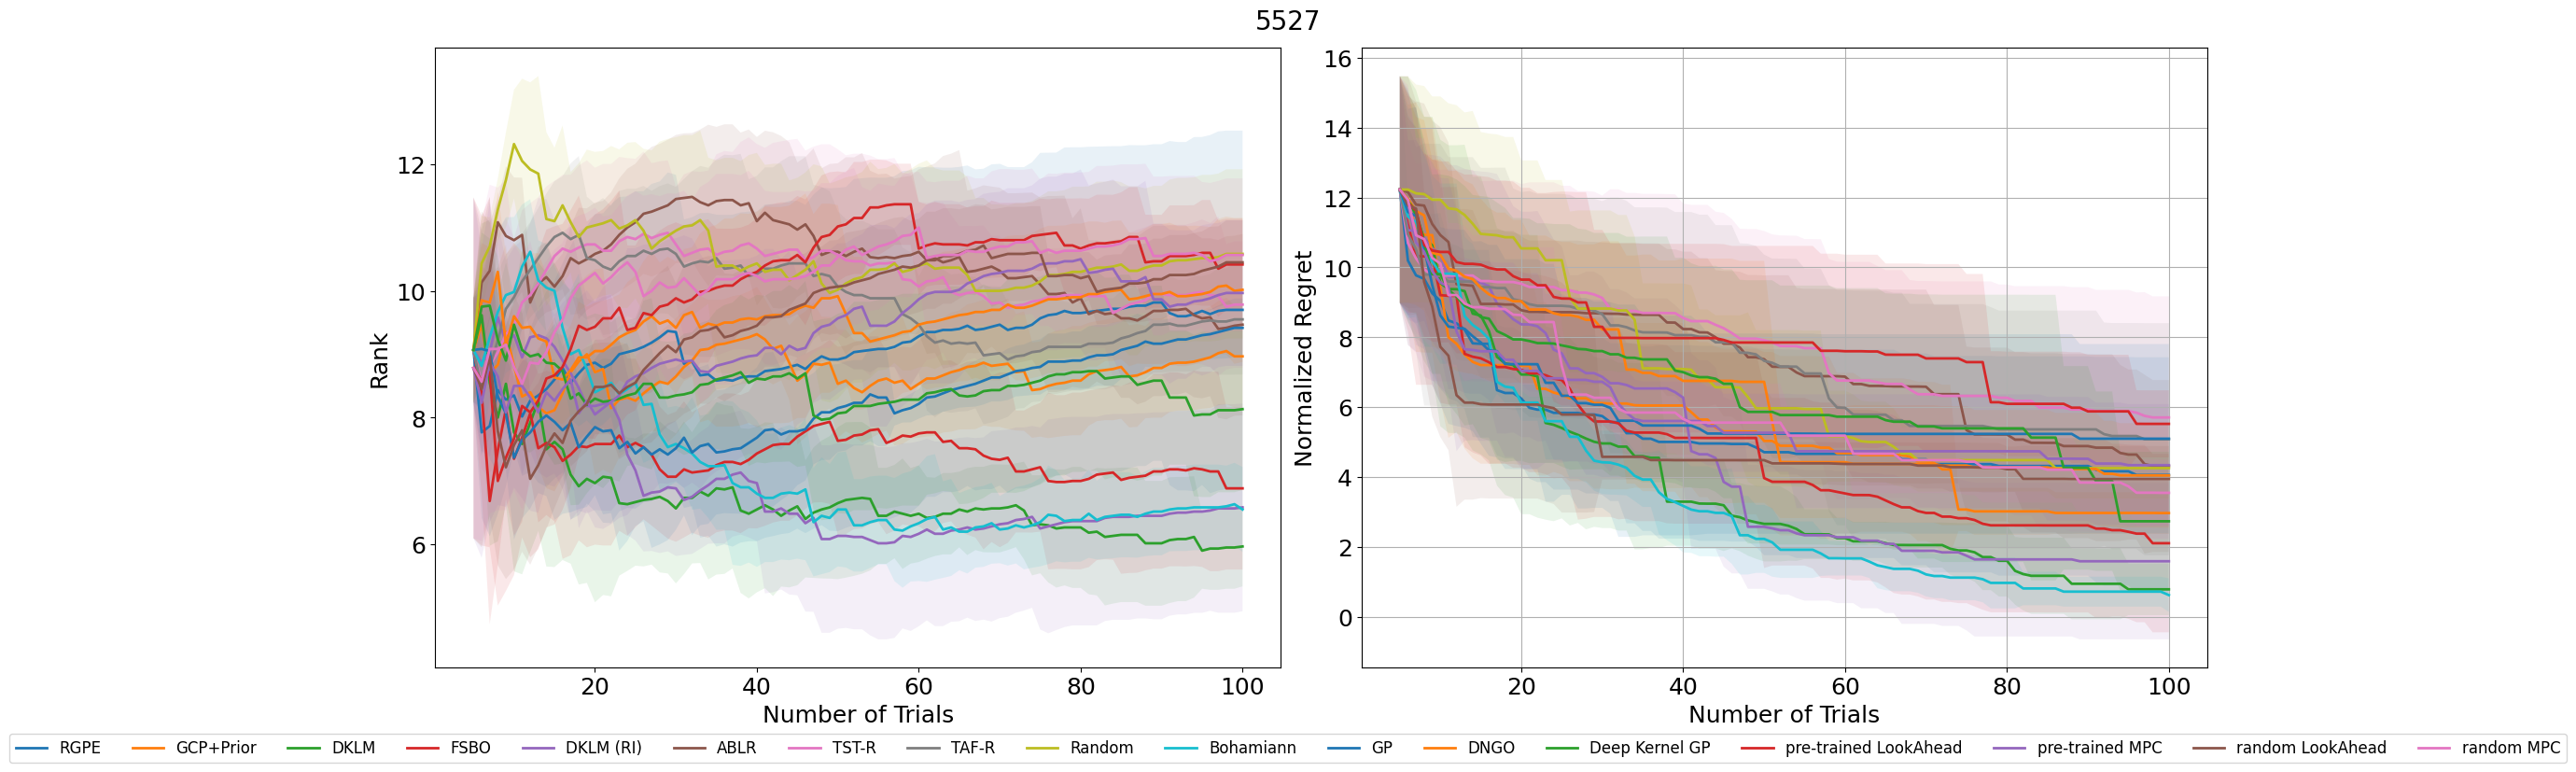

In [22]:
# plotting variables
offset = 5
axis_font = 18
title_font = 20
labelsize = 18
linewidth=2
legend_font=12

fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
x_values = range(offset, offset + search_space_results_rank_mean.shape[0])
subaxs  = axs[0]
for c in col_names:
    _ = subaxs.plot(x_values, search_space_results_rank_mean[c], label=c, linewidth=linewidth)
    _ = subaxs.fill_between(x_values, search_space_results_rank_mean[c] + search_space_results_rank_std[c],
                            search_space_results_rank_mean[c] - search_space_results_rank_std[c], alpha=0.1)
_ = subaxs.grid()
handles, labels = subaxs.get_legend_handles_labels()
subaxs.legend_ = None
_ = subaxs.tick_params(axis='x', labelsize=labelsize)
_ = subaxs.tick_params(axis='y', labelsize=labelsize)
_ = subaxs.grid()
_ = subaxs.set_xlabel("Number of Trials", fontsize=axis_font)
_ = subaxs.set_ylabel("Rank", fontsize=axis_font)

subaxs  = axs[1]
for c in col_names:
    _ = subaxs.plot(x_values, search_space_results_mean[c], linewidth=linewidth)
    _ = subaxs.fill_between(x_values, search_space_results_mean[c] + search_space_results_std[c],
                            search_space_results_mean[c] - search_space_results_std[c], alpha=0.1)
_ = subaxs.grid()
_ = subaxs.set_xlabel("Number of Trials", fontsize=axis_font)
_ = subaxs.set_ylabel("Normalized Regret", fontsize=axis_font)
_ = subaxs.tick_params(axis='x', labelsize=labelsize)
_ = subaxs.tick_params(axis='y', labelsize=labelsize)
_ = fig.legend(handles, labels,loc='lower center',bbox_to_anchor=(0.50, -0.04),ncol=len(col_names), fontsize=legend_font)
_ = fig.suptitle(search_space_id, fontsize=title_font)
_ = plt.tight_layout()

In [23]:
search_space_results_rank_mean.loc[[20, 45, 95]].rename(index={20:25, 45:50, 95:100}).transpose().sort_values(by=100, ascending=True)

,25,50,100
DKLM,6.666667,6.650000,5.966667
Bohamiann,8.550000,6.550000,6.550000
DKLM (RI),7.166667,6.133333,6.583333
FSBO,7.600000,7.633333,6.883333
Deep Kernel GP,8.383333,8.066667,8.133333
GCP+Prior,8.266667,8.533333,8.966667
GP,7.433333,8.150000,9.416667
ABLR,11.083333,10.616667,9.466667
TAF-R,10.550000,10.066667,9.550000
RGPE,9.066667,8.916667,9.700000


In [24]:
search_space_results_mean.loc[[20, 45, 95]].rename(index={20:25, 45:50, 95:100}).transpose().sort_values(by=100, ascending=True)

,25,50,100
Bohamiann,5.600427,2.232647,0.625312
DKLM,5.405786,2.663263,0.790083
DKLM (RI),7.538728,2.580126,1.593154
FSBO,6.776494,3.973001,2.109132
Deep Kernel GP,7.769176,5.866631,2.737320
GCP+Prior,6.360043,5.035429,2.972621
random MPC,7.183500,5.559867,3.550277
random LookAhead,5.790463,4.484790,3.948677
DNGO,8.635979,6.726117,4.047915
RGPE,5.837204,4.712804,4.061223


In [25]:
store_dir = f"../collected/testing/{search_space_id}"
os.makedirs(store_dir, exist_ok=True)
search_space_results_mean.to_csv(os.path.join(store_dir, f"regret–horizon-{horizon}-trajectories-{num_random_trajectories}-particle-{num_particles}.csv"))
search_space_results_rank_mean.to_csv(os.path.join(store_dir, f"rank–horizon-{horizon}-trajectories-{num_random_trajectories}-particle-{num_particles}.csv"))